In [56]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from scipy.stats import chi2_contingency
import scipy.stats as stats
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import SVMSMOTE
from imblearn.over_sampling import ADASYN
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from matplotlib import pyplot as plt
import category_encoders as ce
from sklearn.preprocessing import LabelEncoder
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import StandardScaler
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [57]:
df = pd.read_csv(r'Desktop\ga\hackathon\train.csv')
df.shape

(52310, 11)

In [58]:
test = pd.read_csv(r'Desktop\ga\hackathon\test.csv')
test.shape

(22421, 10)

In [4]:
df.head()

,ID,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Age,Claim
0,2010,EPX,Travel Agency,Online,Cancellation Plan,61,PHILIPPINES,12.0,0.00,41,0
1,4245,EPX,Travel Agency,Online,Cancellation Plan,4,MALAYSIA,17.0,0.00,35,0
2,9251,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,26,THAILAND,19.8,11.88,47,0
3,4754,EPX,Travel Agency,Online,2 way Comprehensive Plan,15,HONG KONG,27.0,0.00,48,0
4,8840,EPX,Travel Agency,Online,2 way Comprehensive Plan,15,MALAYSIA,37.0,0.00,36,0


In [59]:
df_train = df.drop(['ID'],axis=1)

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52310 entries, 0 to 52309
Data columns (total 10 columns):
Agency                  52310 non-null object
Agency Type             52310 non-null object
Distribution Channel    52310 non-null object
Product Name            52310 non-null object
Duration                52310 non-null int64
Destination             52310 non-null object
Net Sales               52310 non-null float64
Commision (in value)    52310 non-null float64
Age                     52310 non-null int64
Claim                   52310 non-null int64
dtypes: float64(2), int64(3), object(5)
memory usage: 4.0+ MB


In [8]:
df_train.describe()

,Duration,Net Sales,Commision (in value),Age,Claim
count,52310.000000,52310.000000,52310.000000,52310.000000,52310.000000
mean,58.256108,48.554673,12.219963,39.555725,0.166699
std,109.138708,60.198589,22.847645,13.762473,0.372710
min,-2.000000,-389.000000,0.000000,0.000000,0.000000
25%,10.000000,19.800000,0.000000,33.000000,0.000000
50%,24.000000,29.500000,0.000000,36.000000,0.000000
75%,57.000000,55.000000,13.380000,43.000000,0.000000
max,4881.000000,682.000000,262.760000,118.000000,1.000000


In [9]:
df_train.describe(include=['O'])

,Agency,Agency Type,Distribution Channel,Product Name,Destination
count,52310,52310,52310,52310,52310
unique,16,2,2,25,97
top,EPX,Travel Agency,Online,Cancellation Plan,SINGAPORE
freq,26218,34996,51419,13254,14242


In [15]:
target=df_train.Claim.value_counts()
target

0    43590
1     8720
Name: Claim, dtype: int64

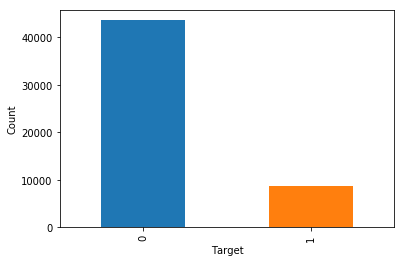

In [16]:
target.plot(kind="bar")
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()

In [11]:
df_train.isnull().sum()

Agency                  0
Agency Type             0
Distribution Channel    0
Product Name            0
Duration                0
Destination             0
Net Sales               0
Commision (in value)    0
Age                     0
Claim                   0
dtype: int64

In [60]:
cat_cols = df_train.select_dtypes(include='object').columns.tolist()
cat_cols

['Agency',
 'Agency Type',
 'Distribution Channel',
 'Product Name',
 'Destination']

# Univariate Analysis of Continuous Features

In [18]:
numcols= df_train.select_dtypes(include=['number']).columns.tolist()
numcols.remove("Claim")

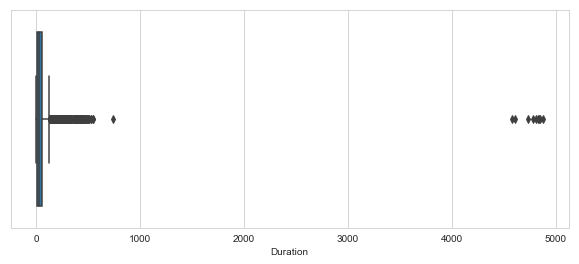

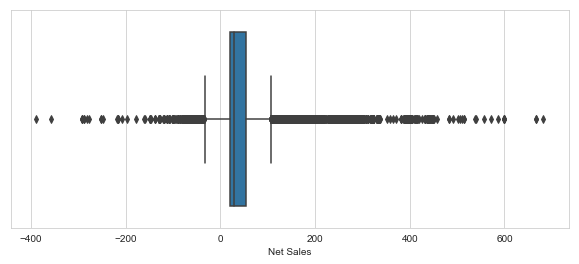

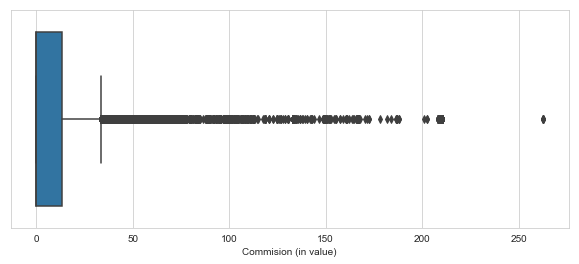

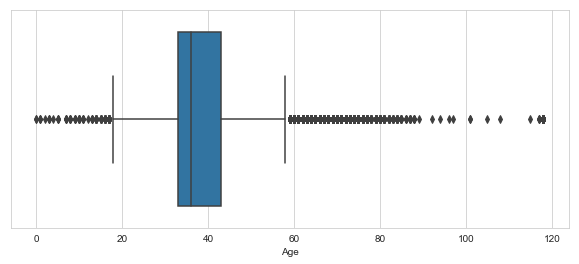

In [19]:
for i in numcols:
    plt.figure(figsize=(10,4))
    sns.set_style('whitegrid')
    sns.boxplot(df_train[i])
    plt.show()

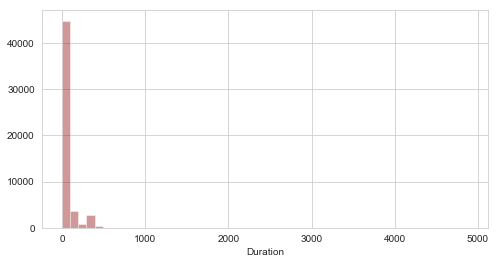

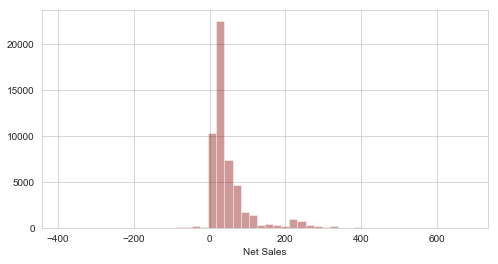

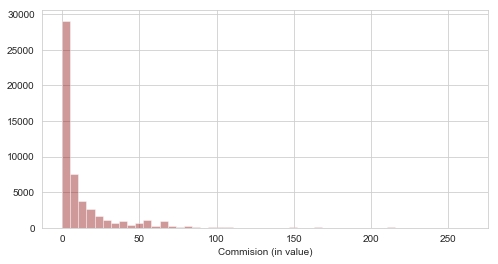

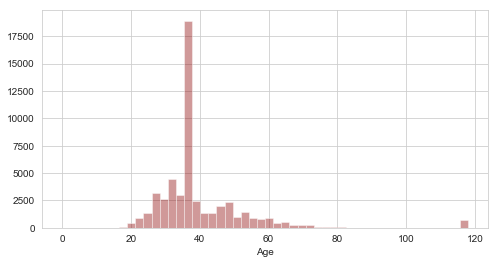

In [20]:
for i in numcols:
    plt.figure(figsize=(8,4))
    sns.set_style('whitegrid')
    sns.distplot(df_train[i],kde=False,color='darkred')
    plt.show()

# Outlier Detection

In [21]:
outliers = pd.DataFrame(columns=['Feature','Number of Outliers'])
for column in numcols:
    # first quartile (Q1)
    q1 = df_train[column].quantile(0.25)            
    # third quartile (Q3)
    q3 = df_train[column].quantile(0.75)
    # IQR
    iqr = q3 - q1
    range_min = q1 - (1.5*iqr)
    range_max = q3 + (1.5*iqr)
    outliers = outliers.append({'Feature':column,'Number of Outliers':df_train.loc[(df_train[column] < range_min) | (df_train[column] > range_max)].shape[0]},ignore_index=True)
print(outliers)

                Feature Number of Outliers
0              Duration               5484
1             Net Sales               5335
2  Commision (in value)               6394
3                   Age               3675


# Univariate analysis of Categorical features

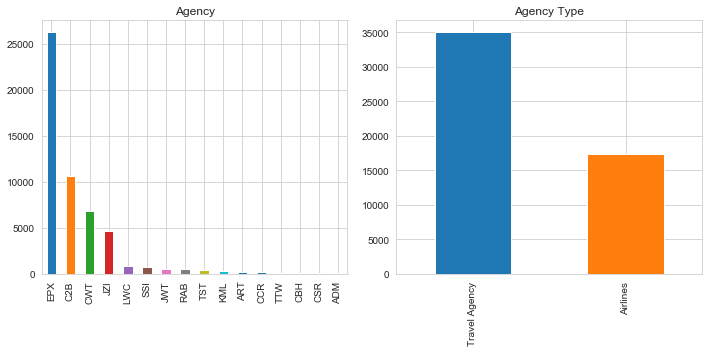

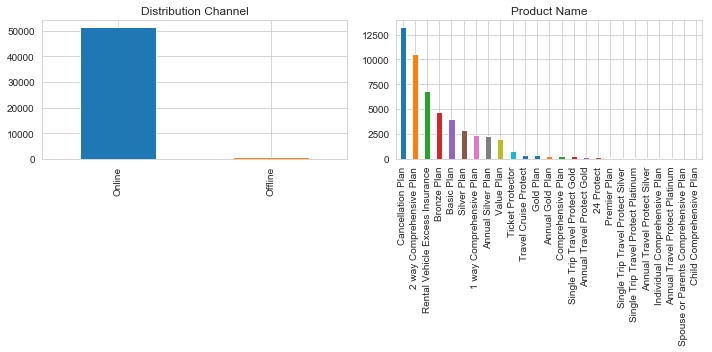

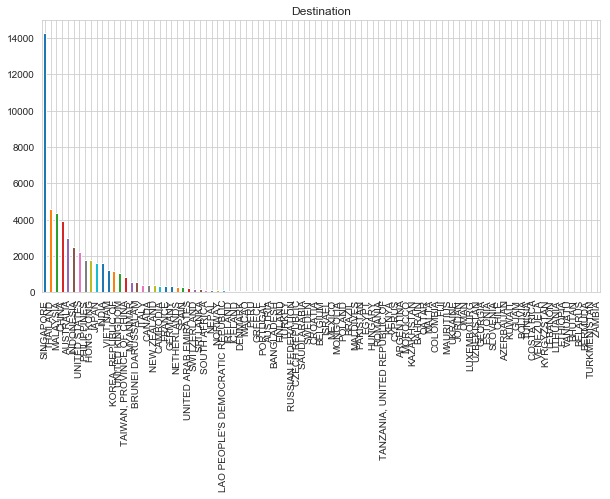

In [23]:
for i in range(0,len(cat_cols),2):
    if len(cat_cols) > i+1:                
        plt.figure(figsize=(10,5))
        plt.subplot(121)
        df_train[cat_cols[i]].value_counts().plot(kind='bar')
        plt.title(cat_cols[i])
        plt.subplot(122)     
        df_train[cat_cols[i+1]].value_counts().plot(kind='bar')
        plt.title(cat_cols[i+1])
        plt.tight_layout()
        plt.show()
    else:
        plt.figure(figsize=(10,5))
        df_train[cat_cols[i]].value_counts().plot(kind='bar')
        plt.title(cat_cols[i])

In [108]:
df_top20 = df_train['Destination'].value_counts().head(20)

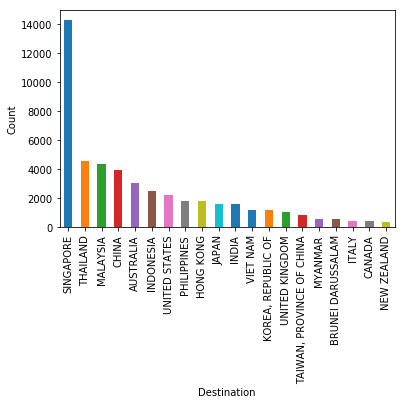

In [110]:
df_top20.plot(kind="bar")
plt.xlabel('Destination')
plt.ylabel('Count')
plt.show()

# Bivariate Analysis of Categorical Features 

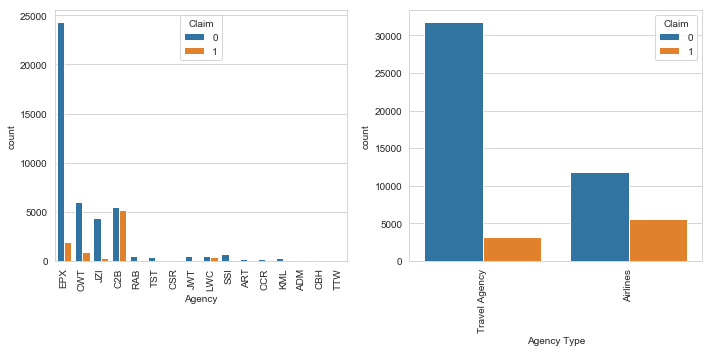

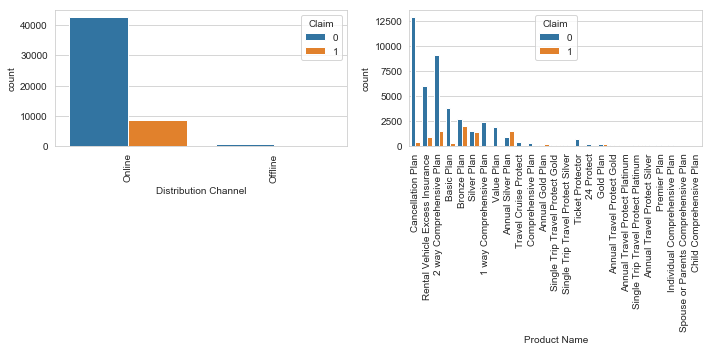

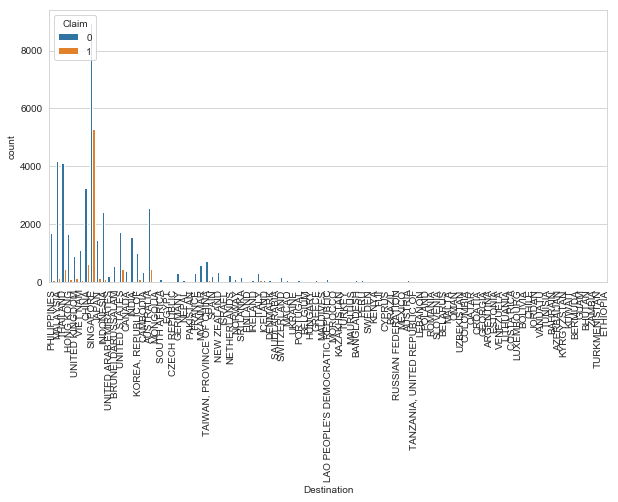

In [36]:
for i in range(0,len(cat_cols),2):
    if len(cat_cols) > i+1:
        plt.figure(figsize=(10,5))
        plt.subplot(121)
        sns.countplot(x=df_train[cat_cols[i]],hue=df_train.Claim,data=df_train)
        plt.xticks(rotation=90)
        plt.subplot(122)            
        sns.countplot(x=df_train[cat_cols[i+1]],hue=df_train.Claim,data=df_train)
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.show()
    else:
        plt.figure(figsize=(10,5))        
        sns.countplot(x=df_train[cat_cols[i]],hue=df_train.Claim,data=df_train)
        plt.xticks(rotation=90)

# Multivariate Analysis of features

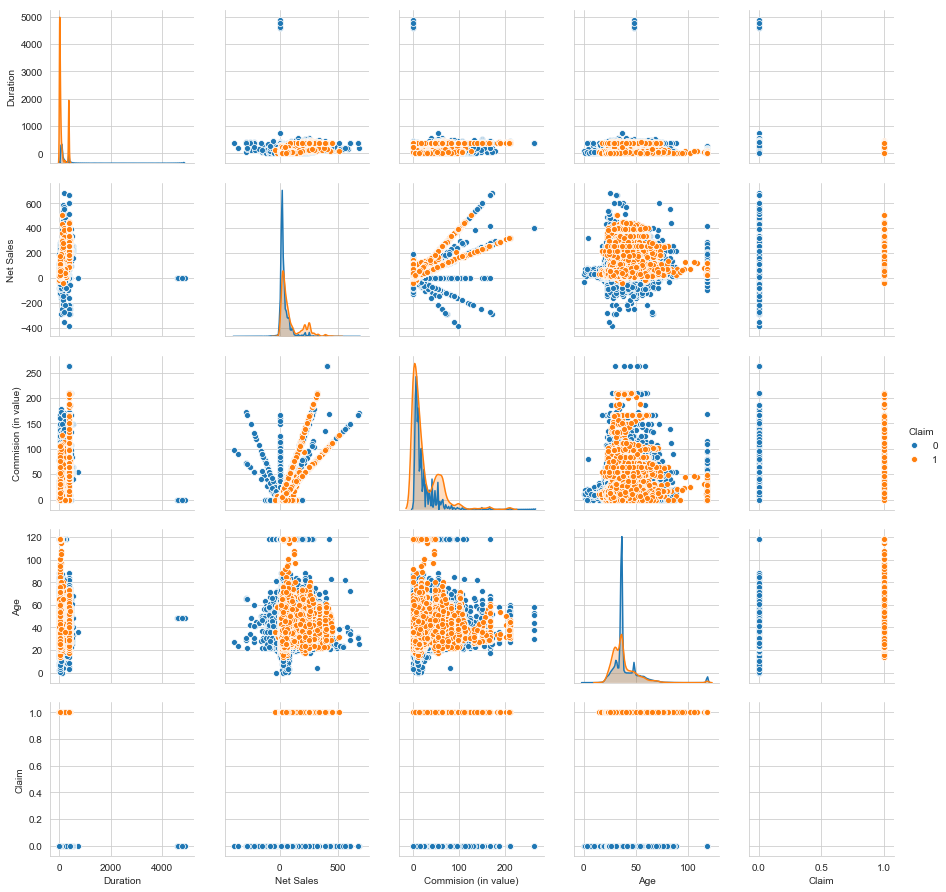

In [39]:
sns.pairplot(df_train,hue='Claim')
plt.show()

# Chi Square test between Agency & Agency Type

In [9]:
observed = pd.crosstab(df_train['Agency'],df_train['Agency Type'])
observed

Agency Type,Airlines,Travel Agency
Agency,,
ADM,0,56
ART,223,0
C2B,10615,0
CBH,0,76
CCR,0,156
CSR,0,60
CWT,0,6813
EPX,0,26218
JWT,550,0


In [10]:
chi2, p, dof, ex = chi2_contingency(observed)
p

0.0

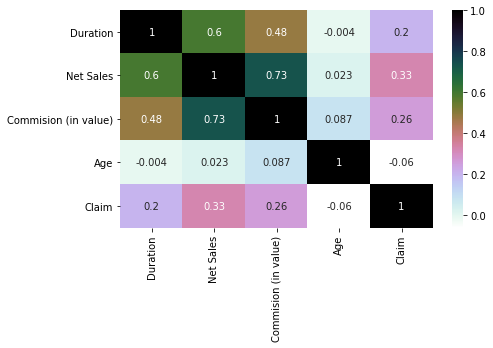

In [30]:
plt.figure(figsize=(7,4)) 
sns.heatmap(df_train.corr(),annot=True,cmap='cubehelix_r')
plt.show()

In [229]:
# Treatment of Outliers:
# for col in numcols:
#     df_train[col] = winsorize(df_train[col], limits=[0.05, 0.1],inclusive=(True, True))

In [13]:
#df_train = df_train[(df_train['Net Sales'] > 0) & (df_train['Duration'] < 4000)]

In [61]:
ID = test[['ID']]
df_test = test.drop(['ID'],axis=1)
y = df_train[['Claim']]
X = df_train.drop(['Claim'],axis=1)

In [62]:
for col in cat_cols:
    encoder  =  ce.BinaryEncoder(cols=[col])
    X =  encoder.fit_transform(X)
    df_test =  encoder.transform(df_test)

In [6]:
# le = LabelEncoder()
# for col in cat_cols:
#     df_train[col] =  le.fit_transform(df_train[col])
# #   df_test[col] =   le.transform(df_test[col])

In [51]:
#X = pd.get_dummies(X,columns = cat_cols)
#df_test = pd.get_dummies(df_test,columns = cat_cols)

In [152]:
#
# def ageband(age):
#     if age <= 20 :
#         return 1
#     elif (age > 20 and age <=40):
#         return 2
#     elif (age > 40 and age <=60):
#         return 3
#     elif (age > 60 and age <=80):
#         return 4
#     else:
#         return 5
#      

In [153]:
#df_train['Age'] = df_train['Age'].apply(lambda x: ageband(x))

In [52]:
X.shape

(52310, 146)

In [53]:
df_test.shape

(22421, 146)

In [63]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.15, random_state=2)

In [27]:
#X_sm, y_sm =  SMOTE().fit_resample(X_train, y_train)

In [194]:
#num_columns = ['Duration', 'Net Sales', 'Commision (in value)']
#scaler = StandardScaler()
#scaler.fit(X_train[num_columns])
#X_train[num_columns] = scaler.transform(X_train[num_columns])
#X_val[num_columns] = scaler.transform(X_val[num_columns])

In [11]:
lr = LogisticRegression(random_state=2)
lr.fit(X_train,y_train)
y_pred = lr.predict(X_val)
print(classification_report(y_val,y_pred))

              precision    recall  f1-score   support

           0       0.87      0.96      0.91      6503
           1       0.63      0.30      0.41      1344

    accuracy                           0.85      7847
   macro avg       0.75      0.63      0.66      7847
weighted avg       0.83      0.85      0.83      7847



In [12]:
rf = RandomForestClassifier(random_state=2)
rf.fit(X_train,y_train)
y_pred = rf.predict(X_val)
print(classification_report(y_val,y_pred))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96      6503
           1       0.84      0.76      0.80      1344

    accuracy                           0.94      7847
   macro avg       0.90      0.87      0.88      7847
weighted avg       0.93      0.94      0.93      7847



In [21]:
xgb_model = XGBClassifier(random_state=2)
xgb_model.fit(X_train,y_train)
y_pred = xgb_model.predict(X_val)
print(classification_report(y_val,y_pred))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      6503
           1       0.64      0.39      0.49      1344

    accuracy                           0.86      7847
   macro avg       0.76      0.67      0.70      7847
weighted avg       0.84      0.86      0.84      7847



# Hyper Parameter Tuning for Random Forest

In [24]:
parameter_grid = {"n_estimators": [200,350,500],
              "max_depth": [20,35,50],
              "max_features": [2,5,10],
              "min_samples_split": [3,5,10]
                }

In [25]:
rf = RandomForestClassifier(random_state=2)
grid_search = GridSearchCV(estimator=rf,param_grid=parameter_grid,n_jobs = -1,cv=5)
grid_search.fit(X_train,y_train)
grid_search.best_params_ 

{'max_depth': 35,
 'max_features': 10,
 'min_samples_split': 5,
 'n_estimators': 350}

In [34]:
rf = RandomForestClassifier(random_state=2,n_estimators=350,max_depth=35,max_features=10,min_samples_split=5)
rf.fit(X_train,y_train)
y_pred = rf.predict(X_val)
precision_score(y_val,y_pred)

0.8689320388349514

In [23]:
print(classification_report(y_val,y_pred))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      6503
           1       0.87      0.79      0.83      1344

    accuracy                           0.94      7847
   macro avg       0.91      0.88      0.90      7847
weighted avg       0.94      0.94      0.94      7847



In [24]:
roc_auc_score(y_val,y_pred)

0.8836082064688092

In [21]:
print(confusion_matrix(y_val,y_pred))

[[6344  159]
 [ 280 1064]]


In [199]:
precision = cross_val_score(rf, X, y, cv=10, scoring='precision')

In [201]:
precision.mean()

0.8634010214601074

In [26]:
Claim = pd.DataFrame(rf.predict(df_test),columns=['Claim'])

In [27]:
submission = pd.concat([ID,Claim],1)

In [30]:
submission.to_csv('Desktop/ga/hackathon/submission.csv',index=False)

# Hyperparameter Tuning for XGBoost

In [64]:
xgb_model = XGBClassifier(random_state=2,
 learning_rate =0.01,
 n_estimators=1800,
 max_depth=35,
 min_child_weight=4,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 reg_alpha=0.005,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1)
xgb_model.fit(X_train,y_train)
y_pred = xgb_model.predict(X_val)
precision_score(y_val,y_pred)

0.8793103448275862

In [65]:
print(confusion_matrix(y_val,y_pred))

[[6349  154]
 [ 222 1122]]


In [36]:
roc_auc_score(y_val,y_pred)

0.9045308415346761

In [115]:
Claim = pd.DataFrame(xgb_model.predict(df_test),columns=['Claim'])
submission = pd.concat([ID,Claim],1)

In [116]:
submission.to_csv('Desktop/ga/hackathon/submission2.csv',index=False)